In [14]:
#loading data

from preprocessing import read_consumption_data
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

df = read_consumption_data()

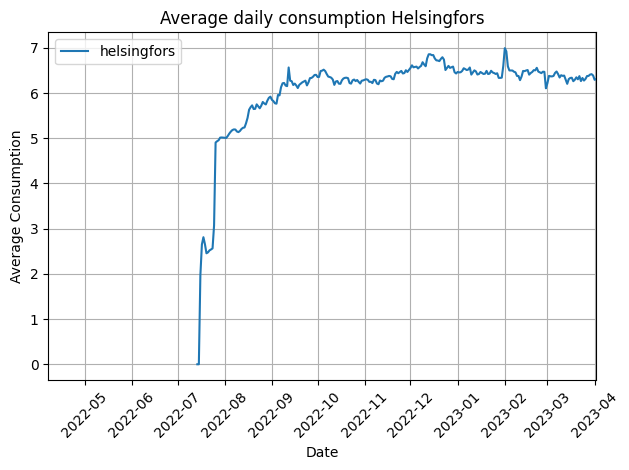

In [19]:
#plotting the consumption for Helsingfors:
date_range = pd.date_range(start=df["time"].dt.date.min(), 
                          end=df["time"].dt.date.max())

daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["consumption"].mean().unstack()
)


daily_avg_consumption_helsingfors = daily_avg_consumption.reindex(date_range)

plt.plot(date_range, daily_avg_consumption_helsingfors["helsingfors"], label = "helsingfors")
plt.title("Average daily consumption Helsingfors")
plt.xlabel("Date")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.xlim(date_range.min(), date_range.max())
plt.tight_layout()
plt.show()


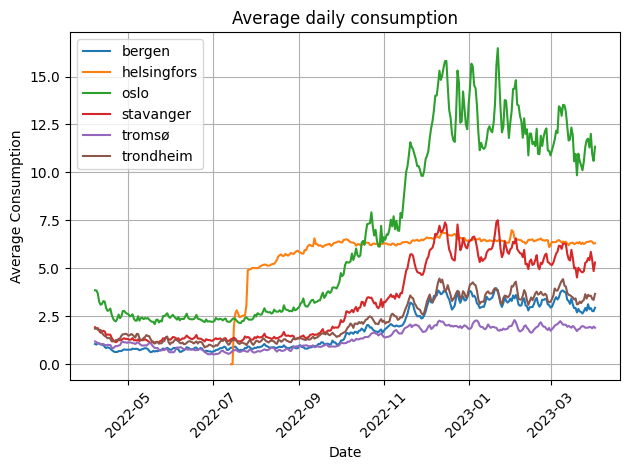

In [21]:
# Plotting average consumprtion for all cities:

daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["consumption"].mean().unstack()
)

for city in daily_avg_consumption.columns:
    plt.plot(daily_avg_consumption.index, daily_avg_consumption[city], label = city)
plt.title("Average daily consumption")
plt.xlabel("Date")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Function defining what season a datapoint belongs to 
def get_season(month, day):
    if (month == 3 and day >= 20) or (month == 4 or month == 5) or (month == 6 and day <= 20):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month == 7 or month == 8) or (month == 9 and day <= 21):
        return 'Summer'
    elif (month == 9 and day >= 22) or (month == 10 or month == 11) or (month == 12 and day <= 20):
        return 'Fall'
    else:
        return 'Winter'


#adding season coloumn
df['season'] = df.apply(lambda row: get_season(row['time'].month, row['time'].day), axis=1)


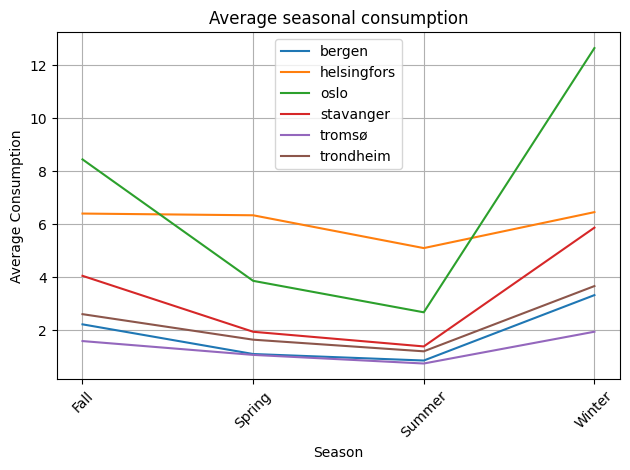

In [27]:
# Plotting average consumption for the cities based on what season it is:
season_avg_consumption= (
    df.groupby([df["season"], "location"])["consumption"].mean().unstack()
)

for city in season_avg_consumption.columns:
    plt.plot(season_avg_consumption.index, season_avg_consumption[city], label = city)
plt.title("Average seasonal consumption")
plt.xlabel("Season")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

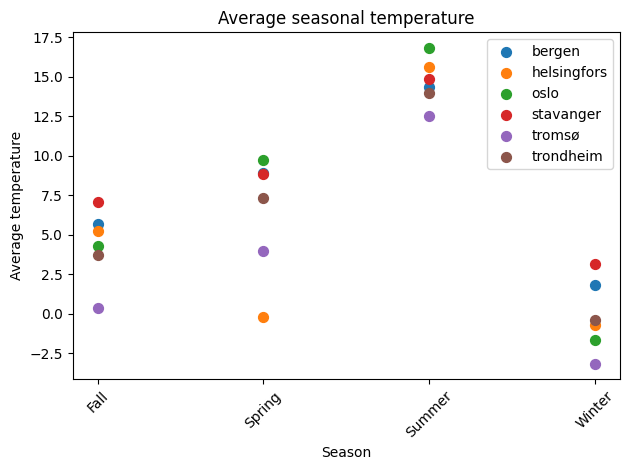

In [31]:
# Plotting average consumption for the cities based on what season it is:
season_avg_temperature= (
    df.groupby([df["season"], "location"])["temperature"].mean().unstack()
)

# Create a scatter plot for each city
for city in season_avg_temperature.columns:
    x_values = range(len(season_avg_temperature.index))
    y_values = season_avg_temperature[city]
    plt.scatter(x_values, y_values, label=city, marker='o', s=50)  # 'o' marker for circles, s for marker size

# Set x-axis labels to be the seasons
plt.xticks(range(len(season_avg_temperature.index)), season_avg_temperature.index)

plt.title("Average seasonal temperature")
plt.xlabel("Season")
plt.ylabel("Average temperature")
plt.legend()
# plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()






